In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
from collections import Counter
import pickle
import argparse
import torch
import sys
from pathlib import Path
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, DistributedSampler
import torch.nn.functional as F


sys.path.insert(0, '..')
from train_binary_cl import (
    get_args_parser,
    RNADataset,
    ROOT_DIR,
    EasyPosAugment,
    RegionSpecNegAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    plot_sample,
    plot_sample2,
    seed_everything,
    pos_width_multipliers, 
    pos_height_multipliers, 
    neg_width_windows, 
    neg_height_windows,
)

from models.binary_classifier import build as build_model, obtain_predictions_ground_truth, calc_metrics
import util.misc as utils
import util.box_ops as box_ops

if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [7]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
original_files_dir = os.path.join(ROOT_DIR, 'dataset', 'original_files')
processed_files_dir = os.path.join(ROOT_DIR, 'dataset', 'processed_files')
rna_rna_files_dir = os.path.join(ROOT_DIR, 'dataset', 'rna_rna_pairs')
ufold_dir = os.path.join(ROOT_DIR, 'UFold_dependencies')
ufold_path= os.path.join(ufold_dir, 'models', 'ufold_train_alldata.pt')
bert_pretrained_dir = os.path.join(ROOT_DIR, 'dataset', 'pre_trained_DNABERT', '6-new-12w-0')

parser = argparse.ArgumentParser('Training', parents=[get_args_parser()])
args = parser.parse_args()
args.output_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl')
args.dataset_path = os.path.join(ROOT_DIR, 'dataset')
args.device = 'cuda:1'
args.resume = args.resume.replace('checkpoint.pth', 'best_model.pth')

seed_everything(123)

df = pd.read_csv(os.path.join(processed_files_dir,"df_cdna.csv"))

sys.path.insert(0, ufold_dir)
from UFold_dependencies.running_ufold import UFoldModel
from util.xai import lime, get_cdna_slices, forward_func, expl_matrix_treshold, cosine_similarity_expl, estimate_bbox
from util.xai import plot_matrix as plot_lime_matrix
UFoldFeatureExtractor = UFoldModel(args.device, ufold_path, eval_mode = True)

==========Start Loading Pretrained Model==========
==========Finish Loading Pretrained Model==========


In [8]:
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    output_dir = Path(args.output_dir)

if os.path.isfile(os.path.join(args.output_dir, 'checkpoint.pth')):
    args.resume = os.path.join(args.output_dir, 'checkpoint.pth')
    
policies = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
    EasyNegAugment(
        per_sample=1,
        width_windows=neg_width_windows,
        height_windows=neg_height_windows,
    ),
    HardPosAugment(
        per_sample=0.5,
        interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
        min_width_overlap=0.3,
        min_height_overlap=0.3,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
    HardNegAugment(
        per_sample=0.5,
        width_windows=neg_width_windows,
        height_windows=neg_height_windows,
    ),
]

In [9]:
dataset_test = RNADataset(
            gene_info_path=os.path.join(processed_files_dir, "df_cdna.csv"),
            interactions_path=os.path.join(processed_files_dir,"df_annotation_files_cleaned.csv"), #subset_valentino.csv
            dot_bracket_path=os.path.join(processed_files_dir,"dot_bracket.txt"),
            df_genes_path = os.path.join(processed_files_dir,"df_genes.csv"),
            subset_file = os.path.join(rna_rna_files_dir, "gene_pairs_val_random_filtered.txt"),
            augment_policies=policies
        )

device = torch.device(args.device)
model, criterion, postprocessors = build_model(args, bert_pretrained_dir, ufold_path)
model.to(device)
model_without_ddp = model

checkpoint = torch.load(args.resume, map_location='cpu')
model_without_ddp.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [11]:
model.eval()
criterion.eval()


for s in tqdm(dataset_test):
    real = 1 if s['policy'] in ['hardpos', 'easypos'] else 0
    if real == 1:
        cdna1_slice, cdna2_slice = get_cdna_slices(s)
        probability = forward_func(cdna1_slice, cdna2_slice, s, model, UFoldFeatureExtractor, device)
        if (probability>0.5):
            print(probability)
            break

  0%|          | 0/1315 [00:00<?, ?it/s]

tensor(0.9373, device='cuda:1', grad_fn=<SelectBackward>)


In [13]:
n_iters = 2
max_perturbations_per_iter = 1000

start_time = time.time()
expl_matrix, score = lime(cdna1_slice, cdna2_slice, n_iters, max_perturbations_per_iter, probability, s, model, UFoldFeatureExtractor, device)
end_time = time.time()

total_minutes = np.round((end_time-start_time)/60, 2)

print(f'Score: {score}')

expl_matrix_tr = expl_matrix_treshold(expl_matrix, treshold = 99, normalize = True)

s_bbox = s['sample_bbox']
int_bbox = s['interaction_bbox']
x1 = int_bbox.x1-s_bbox.x1
x2 = int_bbox.x2-s_bbox.x1
y1 = int_bbox.y1-s_bbox.y1
y2 = int_bbox.y2-s_bbox.y1
w = x2-x1
h = y2-y1

Intercept -0.3943780367418106
Prediction_local [0.93711589]
Right: 0.9373433589935303
Score: 0.9999997517263567


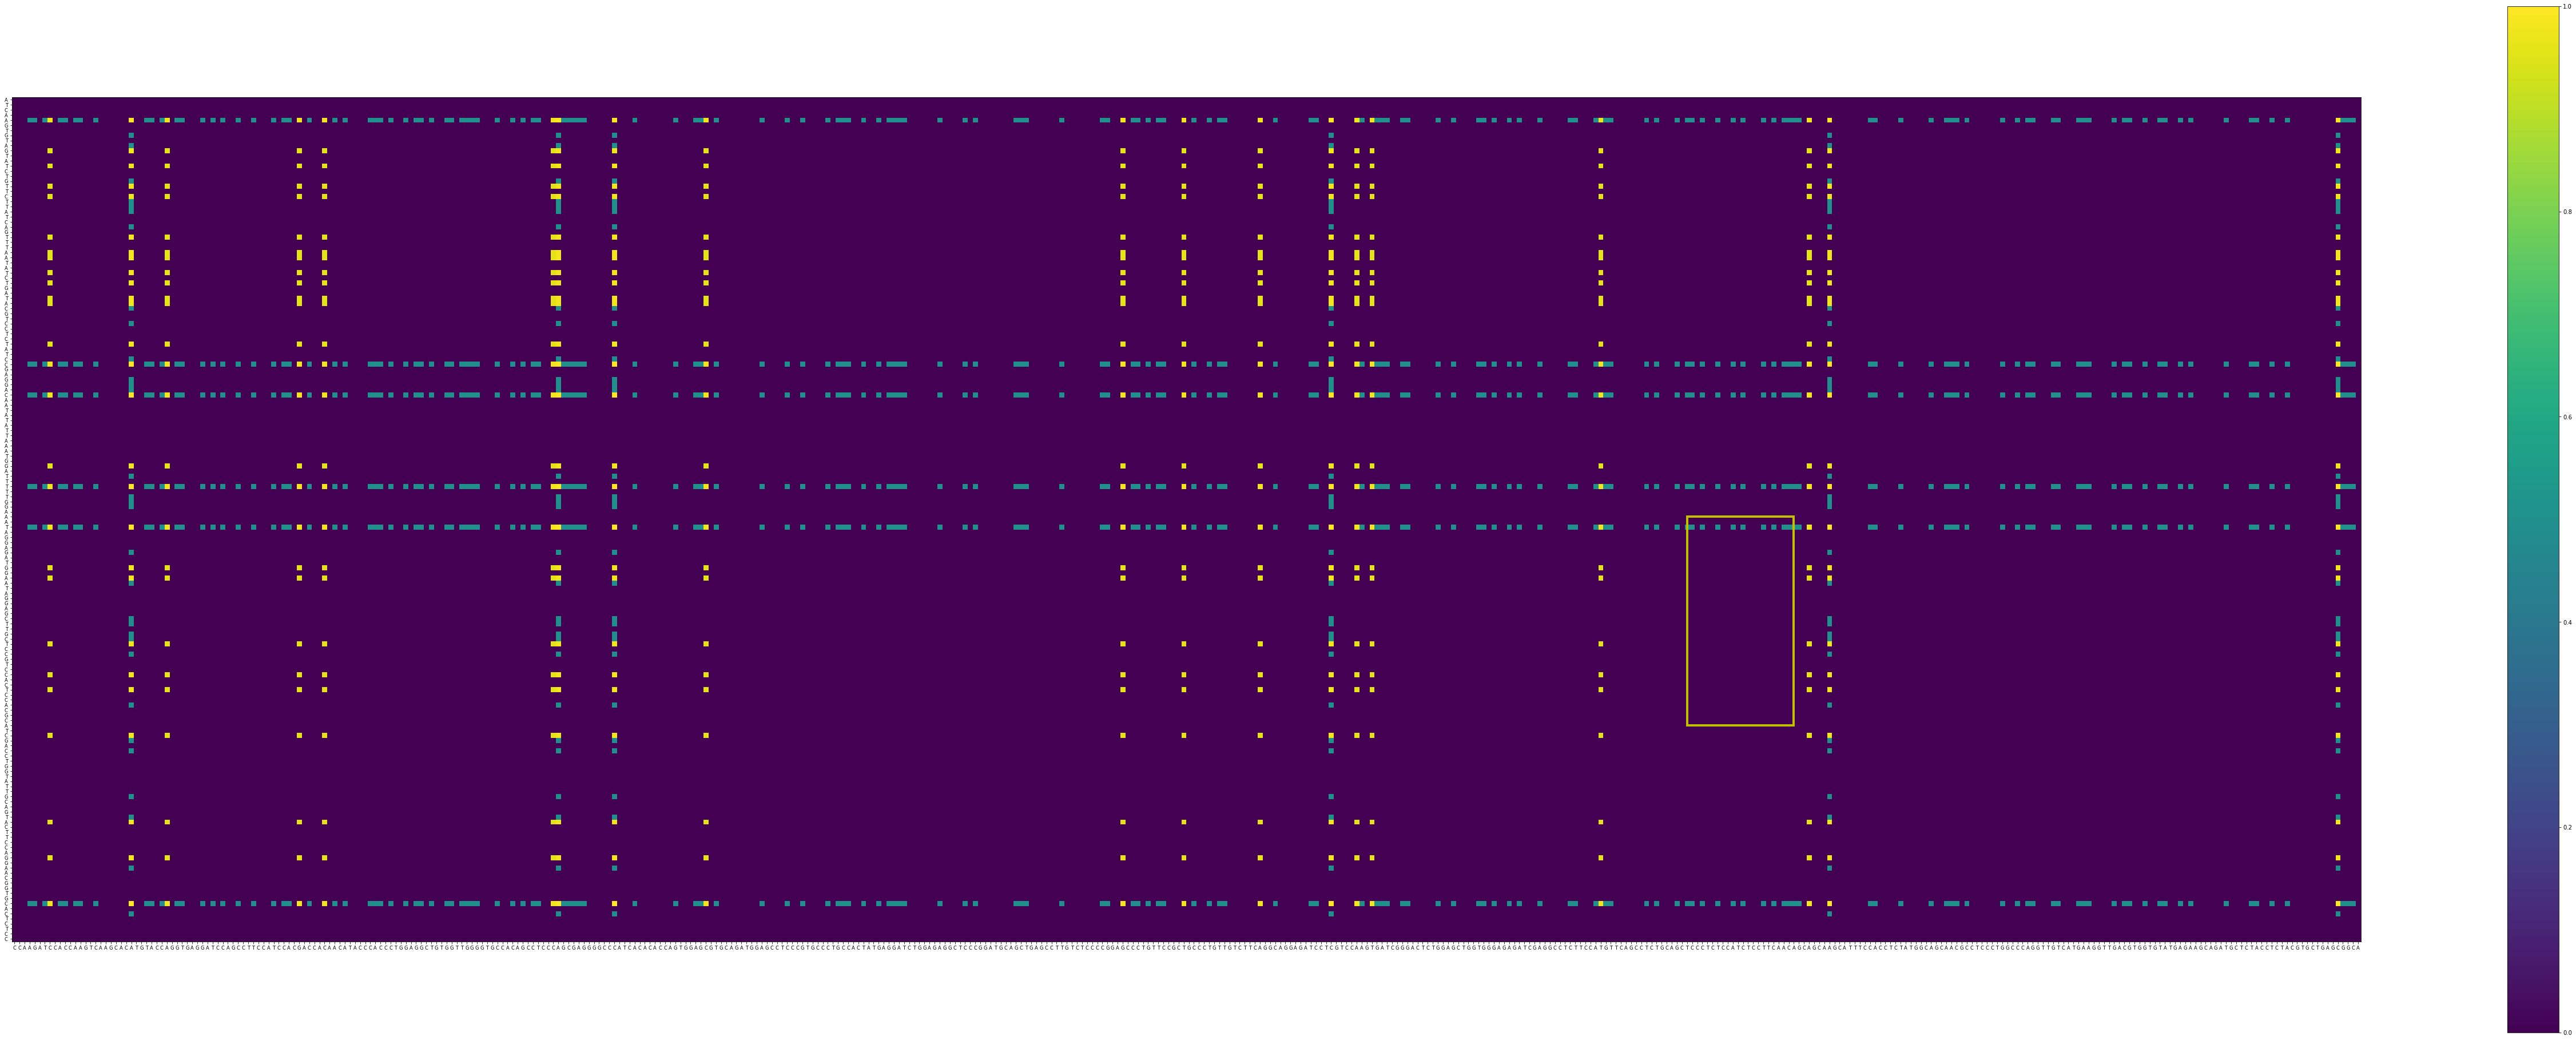

In [18]:
plot_lime_matrix(expl_matrix_tr, cdna1_slice, cdna2_slice, [[x1, y1, w, h]])
cos_sim = float(np.round(cosine_similarity_expl(expl_matrix_tr, [x1, x2, y1, y2]), 3))

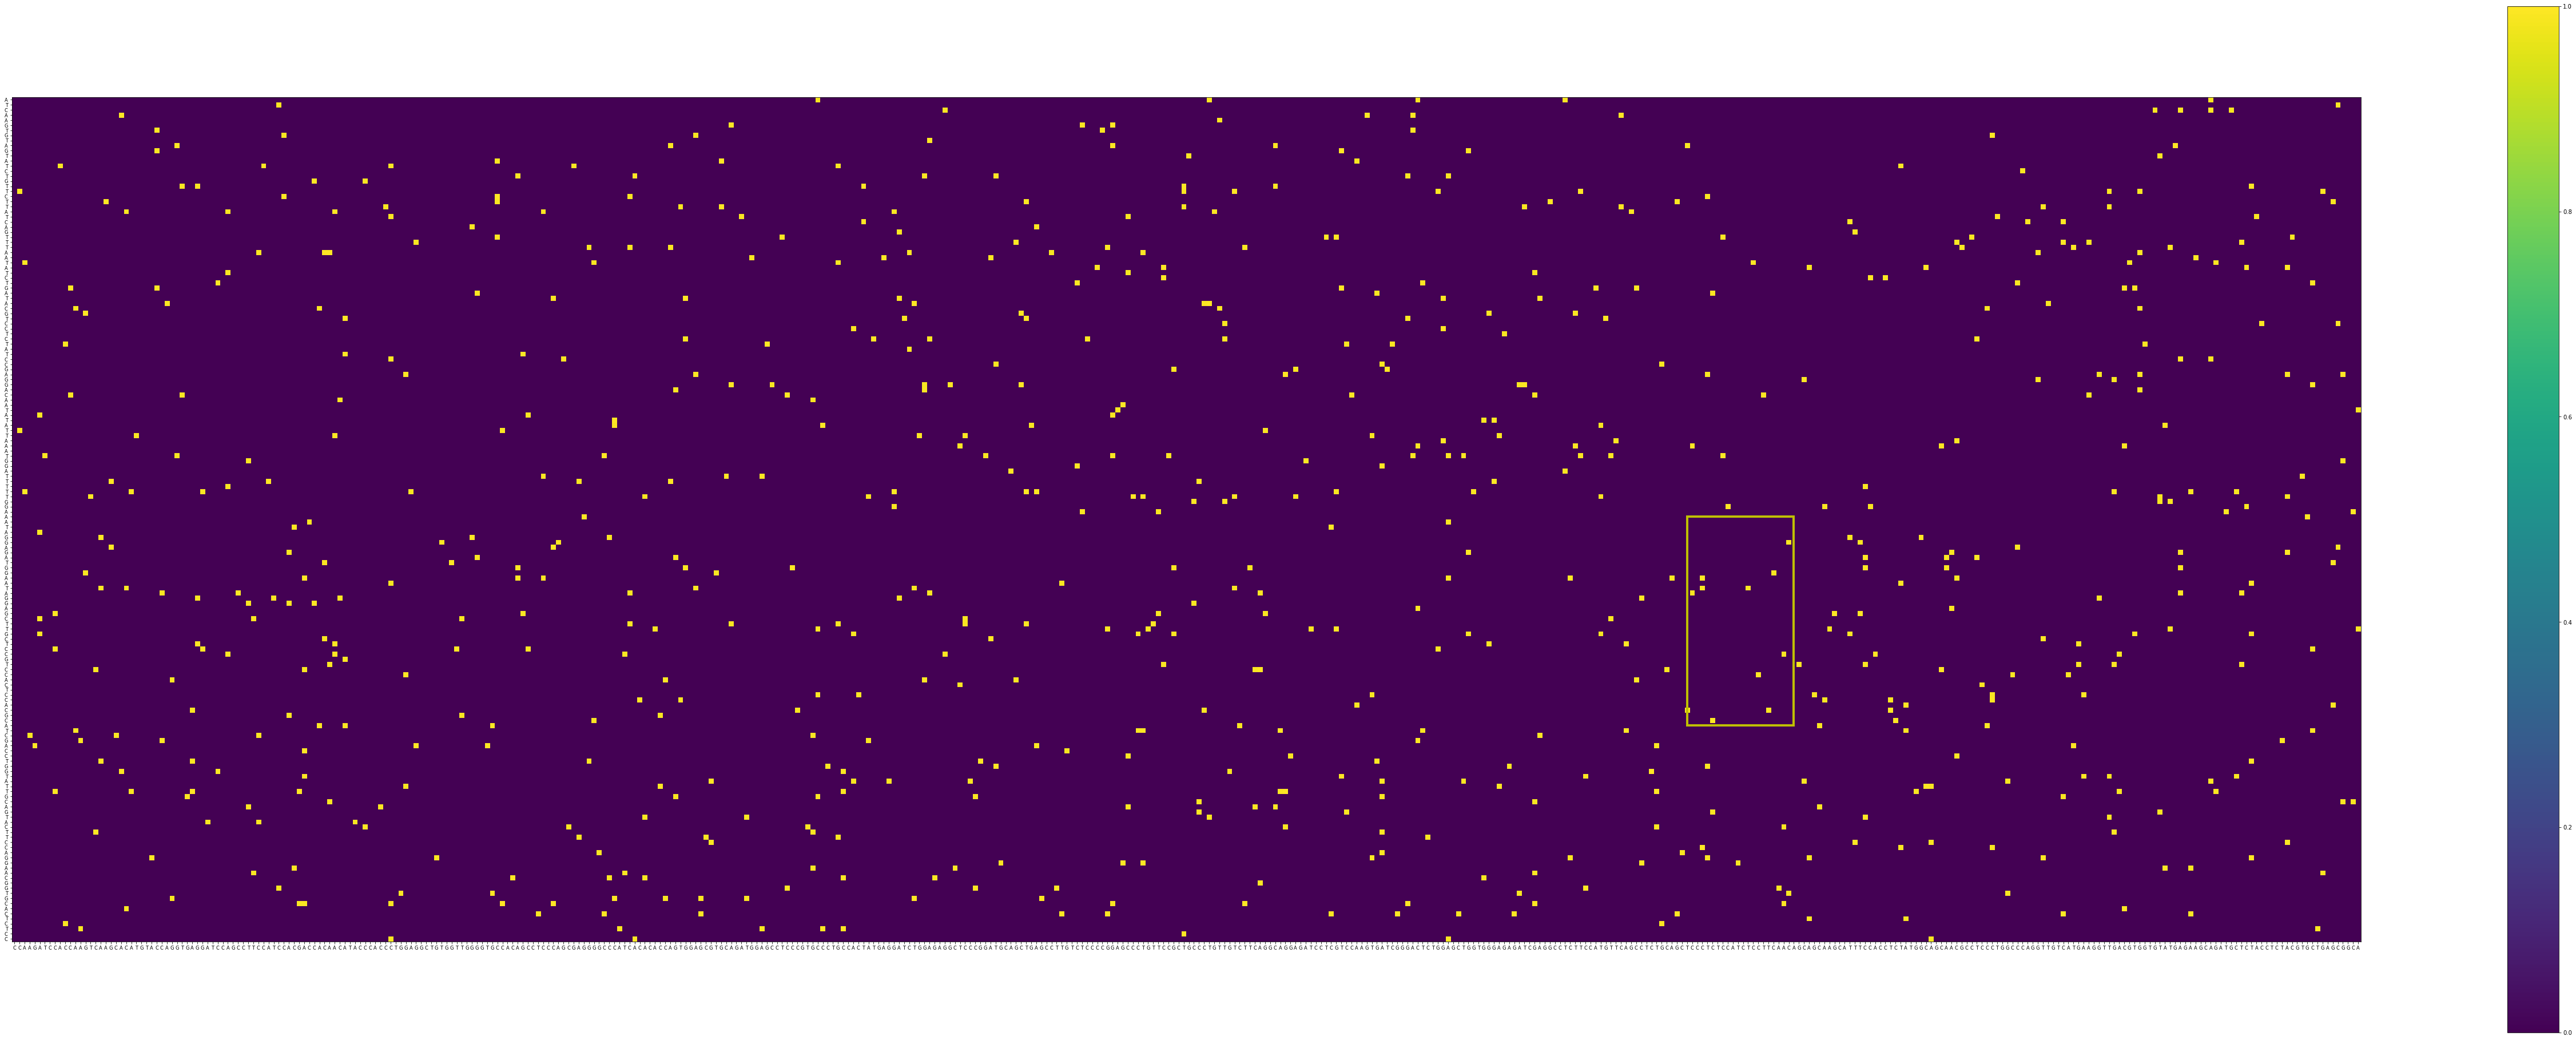

In [19]:
random_expl_matrix = np.random.rand(expl_matrix_tr.shape[0], expl_matrix_tr.shape[1])
random_expl_matrix = expl_matrix_treshold(random_expl_matrix, treshold = 99, normalize = True)
plot_lime_matrix(random_expl_matrix, cdna1_slice, cdna2_slice, [[x1, y1, w, h]])
cos_sim_random = float(np.round(cosine_similarity_expl(random_expl_matrix, [x1, x2, y1, y2]), 3))

In [20]:
print(f'cosine similarity: {cos_sim} \ncosine similarity random: {cos_sim_random}')

cosine similarity: 0.007 
cosine similarity random: 0.013


In [22]:
x1hat, y1hat, what, hhat = estimate_bbox(expl_matrix_tr, desired_dim = 45)

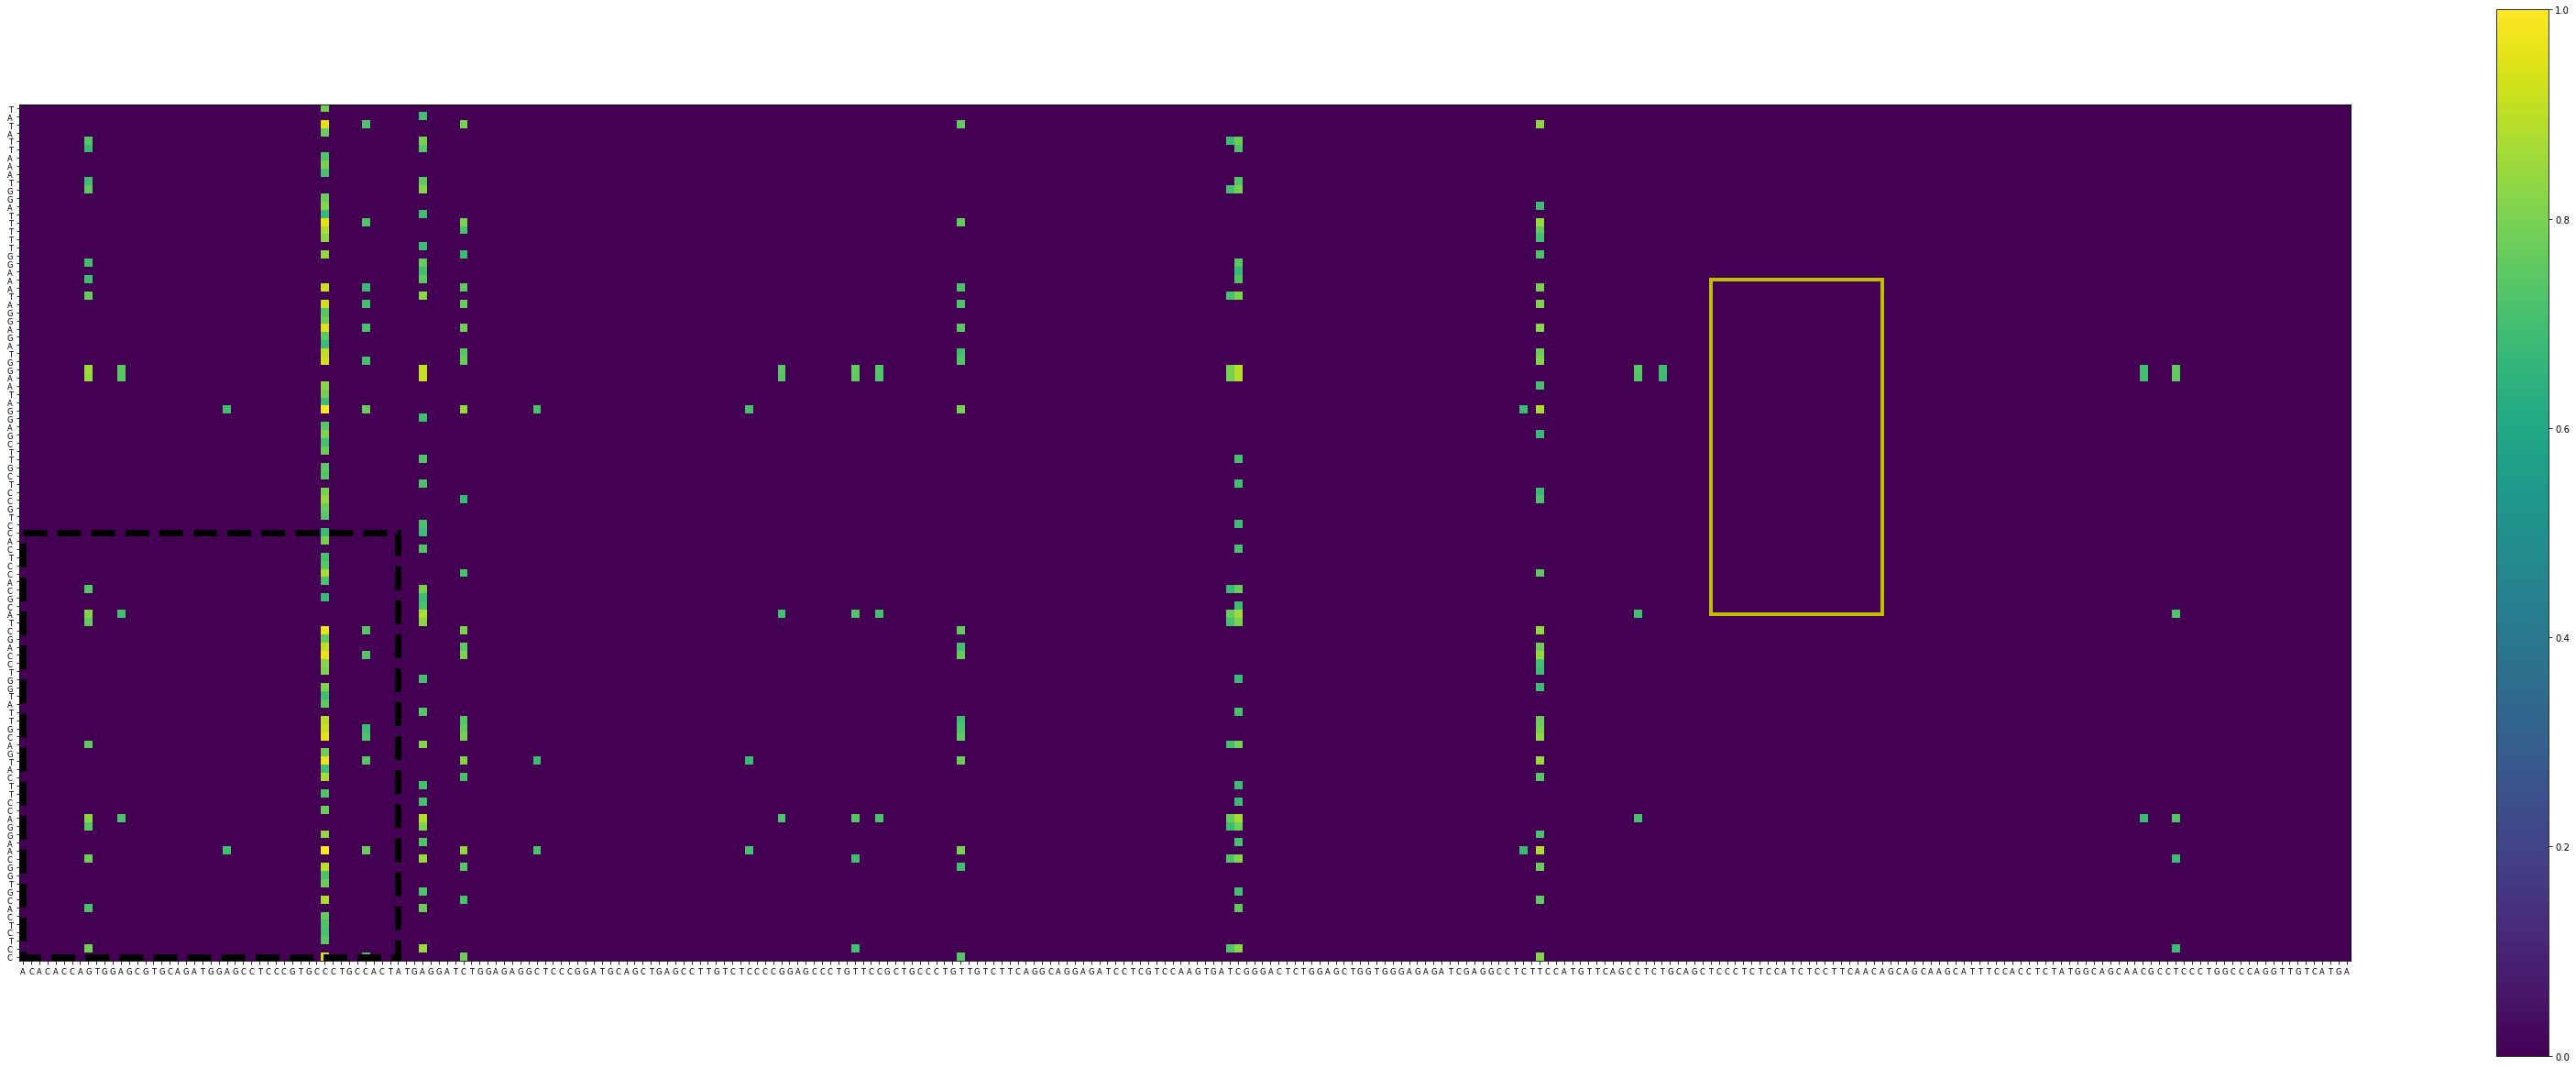

In [23]:
plot_lime_matrix(expl_matrix_tr, cdna1_slice, cdna2_slice, [[x1, y1, w, h]], crop_bbox =[x1hat, y1hat, what, hhat])

In [24]:
iou_value = float(np.round(box_ops.iou_metric([x1hat, y1hat, what, hhat], 
                                              [x1, y1, w, h]), 
                           2))

In [25]:
random_x1, random_y1, random_w, random_h = estimate_bbox(random_expl_matrix, desired_dim = 45)

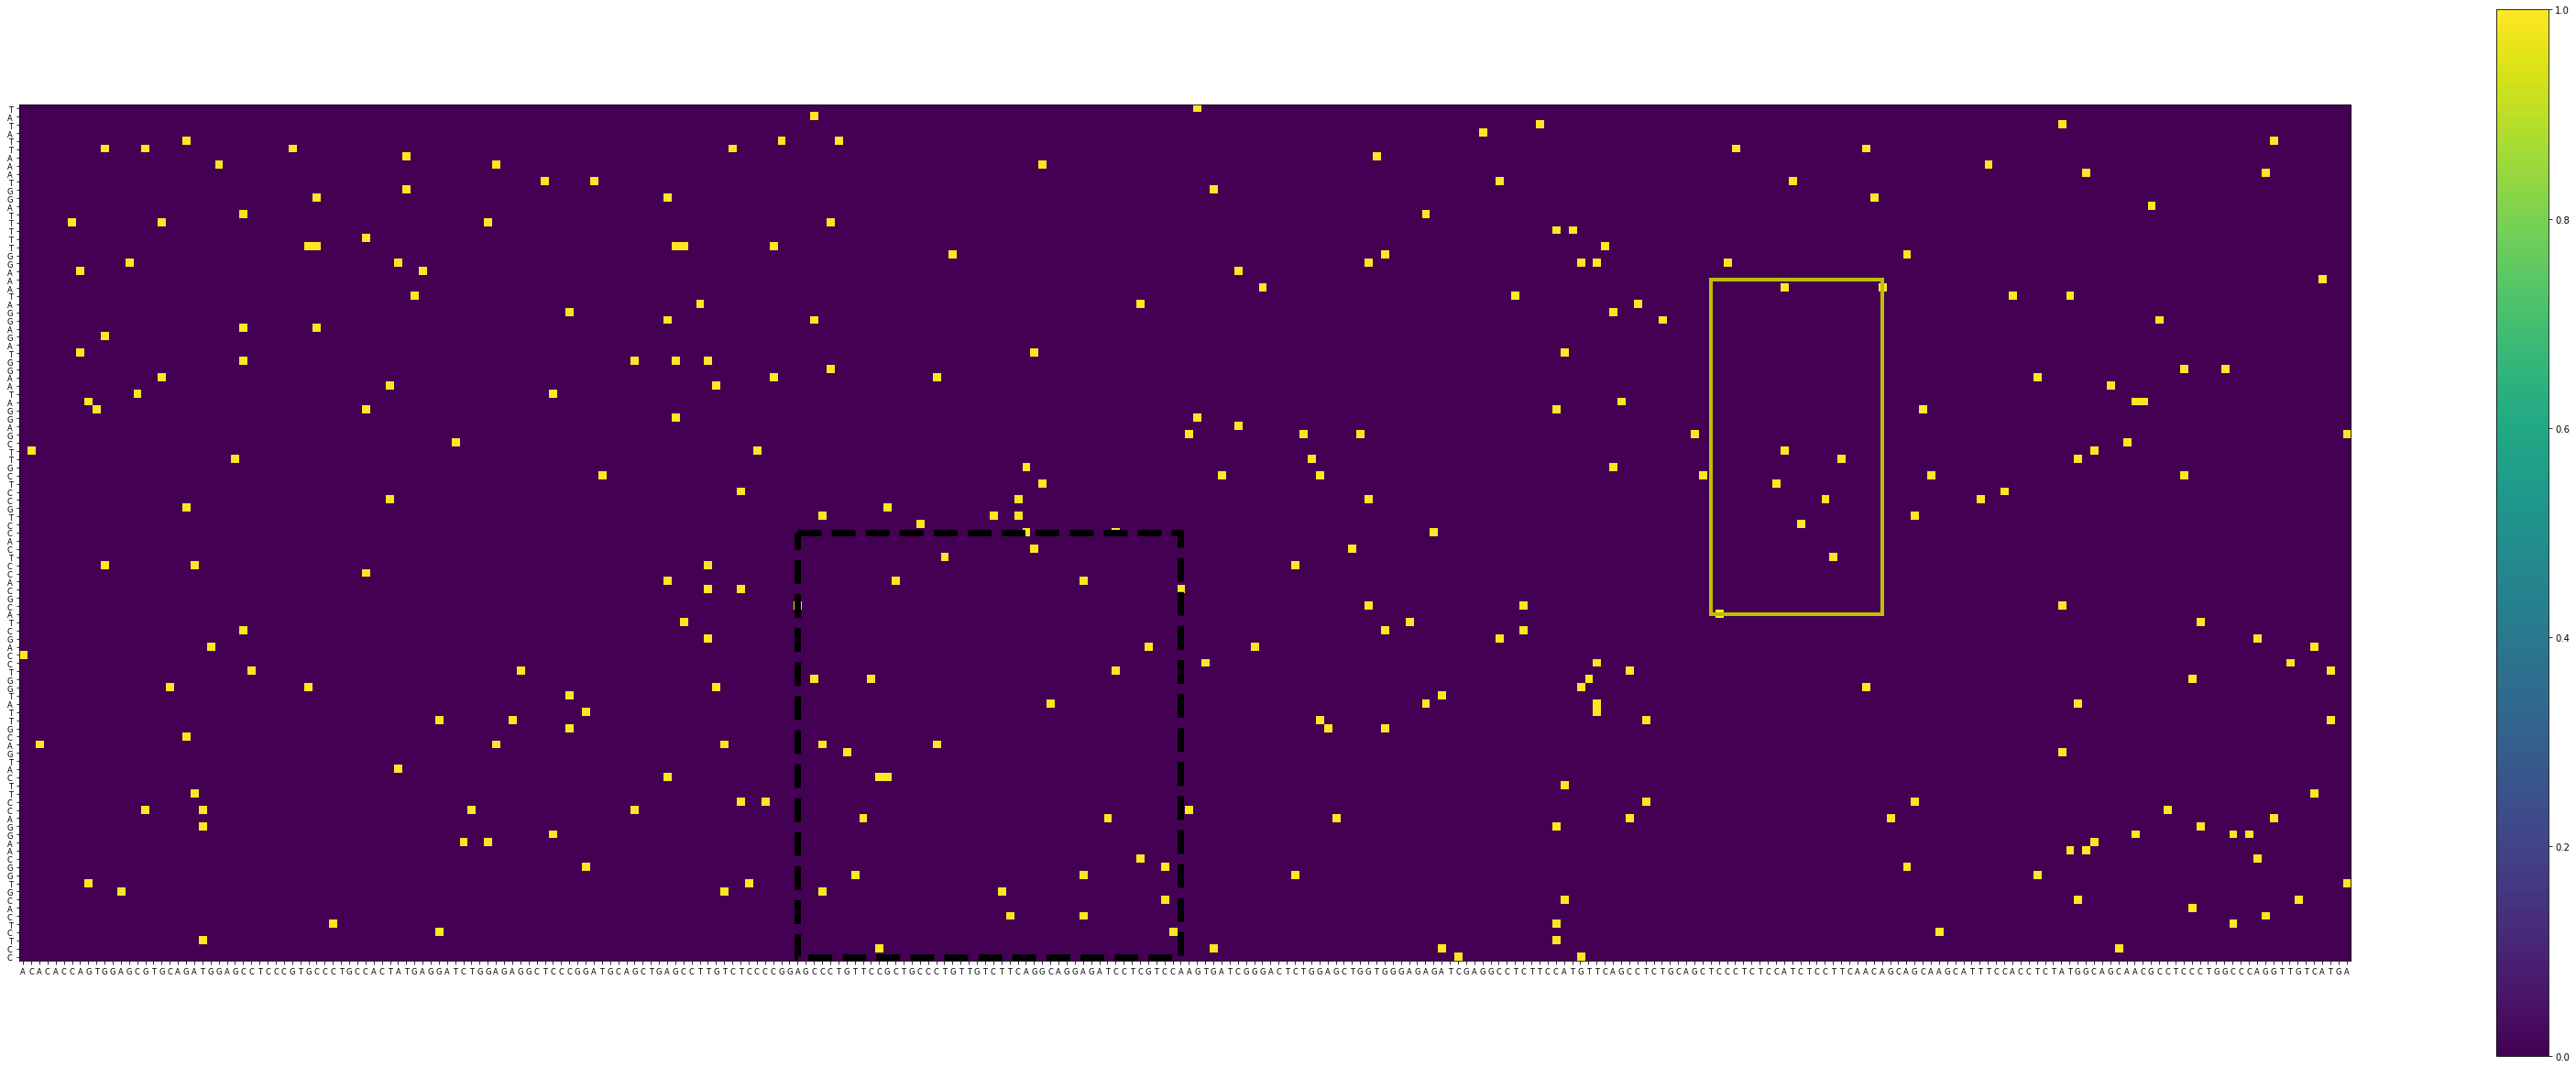

In [33]:
plot_lime_matrix(random_expl_matrix, cdna1_slice, cdna2_slice, [[x1, y1, w, h]], 
                 crop_bbox =[random_x1, random_y1, random_w, random_h])

In [27]:
iou_random = float(np.round(box_ops.iou_metric([random_x1, random_y1, random_w, random_h], 
                                               [x1, y1, w, h]), 
                            2))

#### Read results

In [4]:
res = pd.read_csv(os.path.join(processed_files_dir, 'lime_results.txt'), sep = ' ')

In [5]:
res.time.mean()

22.93116279069768

In [6]:
res.shape

(86, 28)

In [7]:
res['iou_value'].mean()

0.010348837302867753

In [8]:
res['iou_random'].mean()

0.02011627929155216

In [9]:
res['cos_sim'].mean()

0.0068953488372093035

In [10]:
res['cos_sim_random'].mean()

0.009825581395348842

In [ ]:
#These are the evaluated boxes 

#output is the one defined inside the function estimate_bbox
"""
coords = []
for xs in range(output.shape[0]):
    for ys in range(output.shape[1]):
        x1_, y1_ = (bbox_dim * (xs, ys))
        x2_, y2_ = (bbox_dim * (xs + 1, ys+1))
        w_, h_ = x2_-x1_, y2_-y1_
        coords.append([x1_, y1_, w_, h_])
        
plot_lime_matrix(expl_matrix_tr, cdna1_slice, cdna2_slice, coords)
"""